In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pretrain/resnet_50.pth
/kaggle/input/mia-hw-3/submission.csv
/kaggle/input/mia-hw-3/train.csv
/kaggle/input/mia-hw-3/test.csv
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img1.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img10.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img14.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img6.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img16.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img12.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img17.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img15.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img3.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img8.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img5.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img21.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img2.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img7.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img11.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img18.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img4.dcm
/kaggle/input/mia-

In [2]:
!pip install pydicom
!pip install torchsummary

In [3]:
import warnings
import gc
import os
import random

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import pydicom
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
root = "/kaggle/input/mia-hw-3"

train_data = pd.read_csv(os.path.join(root, "train.csv"))
print(f"Numbers of train data : {len(train_data)}")
train_data.head(10)

Numbers of train data : 80


ID  Disease
0   545876        0
1   517509        0
2     4194        0
3     8098        0
4   230450        0
5   193329        0
6   889904        0
7  1126761        1
8   310883        0
9   347447        0

In [6]:
train_data_label_dist = pd.DataFrame(
    {
        "label" : train_data.iloc[:, 1].value_counts().sort_index().index.astype(str),
        "counts" : train_data.iloc[:, 1].value_counts().sort_index().values
    }
)
train_data_label_dist

label  counts
0     0      40
1     1      40

In [7]:
# image interpolation
class Interpolate():
    
    def __init__(self, target_num = 22):
        self.target_num = target_num
    
    def __call__(self, slices): # (3, XX, 512, 512) 其中 XX 是切片的數量
        slices = slices.unsqueeze(dim = 0) # (1, 3, XX, 512, 512)
        slices = F.interpolate(
                  slices, 
                  mode = 'trilinear',
                  size = (self.target_num, slices.shape[-2], slices.shape[-1])) # (1, 3, target_num, 512, 512) 其中 slices.shape[-2], slices.shape[-1]為 XX 張 slice 的 H, W
        return torch.transpose(slices.squeeze(), 0, 1) # slices.squeeze()的形狀為 (3, 22, 512, 512)， 經過 transpose 後形狀變為 (22, 3, 512, 512)

In [8]:
def build_transform(is_train):
    t = []
    if is_train:       
        t.append(Interpolate(target_num = 22))
        #t.append(transforms.RandomRotation(5))  # 隨機旋轉
        return v2.Compose(t)

    t.append(Interpolate(target_num = 22))
    return v2.Compose(t)

In [9]:
def evaluator(preds, gts):
    preds = preds.cpu().detach().numpy() 
    gts = gts.cpu().numpy() 
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

In [10]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []

    for images, labels in train_loader:
        
        images = [image.to(device=device, dtype=torch.float) for image in images]
        labels = labels.to(device=device, dtype=torch.long)

       
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        
        scheduler.step()

        
        train_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)

    
    train_loss /= len(train_loader)

    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100 * train_acc, 100 * train_f1


In [11]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = [image.to(device=device, dtype=torch.float) for image in images]
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

In [12]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in test_loader:
            
            images = [image.to(device=device, dtype=torch.float) for image in images]
            logits = model(images)
            pred = torch.argmax(logits, dim=1)

            preds.append(pred)


    preds = torch.cat(preds)

    return preds

In [13]:
class MRI2DDataset(Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/mia-hw-3"
        self.ids = np.array(df["ID"])
        self.labels = torch.from_numpy(np.array(df["Disease"]))
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in np.array(df["ID"]):
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(root, "DICOM", path, "T1")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img)
                
                # T2 images
                img = pydicom.dcmread(os.path.join(root, "DICOM", path, "T2", filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0))
                
            slices = torch.stack(all_slices, dim = 1)
            
            if self.transforms:
                slices = self.transforms(slices) 
            
            # 這邊有修改
            image = []
            for i in range(len(slices)):
                image.append(slices[i].squeeze().float()) 
            self.images.append(image)
                            
            
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

In [14]:
root = "/kaggle/input/mia-hw-3"
df = pd.read_csv(os.path.join(root,"train.csv"))
dataset_2D = MRI2DDataset(df = df, mode = "train",transforms = build_transform(True))

print(len(dataset_2D))
print(len(dataset_2D[0])) # dataset_2D[0]是一個tuple: ([(3, 256, 256), ...,(3, 256, 256)], label)
print(len(dataset_2D[0][0])) # dataset_2D[0][0] 則是 [(3, 256, 256), ...,(3, 256, 256)]
print(dataset_2D[0][0][0].shape) # dataset_2D[0][0][0] 則是 (3, 256, 256)

# 使用 del 刪除不需要的變數，以釋放出這些變數佔用的 CPU 記憶體。當變數被 del 刪除後，Python 會標記這些記憶體為可回收狀態。
del dataset_2D
# 強制回收內存
gc.collect() 

100%|██████████| 80/80 [01:05<00:00,  1.22it/s]

80
2
22
torch.Size([3, 256, 256])


0

In [24]:
class config:

    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2
    batch_size = 2
    lr = 0.005
    epochs = 30
    weight_decay = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


In [16]:
class MRI3DDataset(torch.utils.data.Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/mia-hw-3"
        self.ids = np.array(df["ID"])
        self.labels = torch.tensor(df["Disease"].values) 
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in self.ids:
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(root, "DICOM", path, "T1")
            T2_root = os.path.join(root, "DICOM", path, "T2")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img) 
                
                # T2 images
                img = pydicom.dcmread(os.path.join(T2_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0)) 
                # 其中 torch.stack((T1_image, T2_image, T1T2_image), dim = 0) 的形狀是 (3, 512, 512)
            
            slices = torch.stack(all_slices, dim = 1) # (3, XX, 512, 512) XX為原始切片數量
            
            if self.transforms:
                slices = self.transforms(slices) # (22, 3, 256, 256)
                slices = torch.transpose(slices, 0, 1) # (3, 22, 256, 256)
            
            self.images.append(slices.float())
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

In [17]:
train_df = pd.read_csv(os.path.join(config.root,"train.csv"))
print("Initializing dataset...")
dataset = MRI3DDataset(train_df, mode = "train", transforms = build_transform(True))

print(dataset[0][0].shape)
del dataset
gc.collect()

Initializing dataset...


100%|██████████| 80/80 [00:31<00:00,  2.53it/s]

torch.Size([3, 22, 256, 256])


0

In [18]:
# 載入github資源
!git clone https://github.com/Tencent/MedicalNet.git
import sys
sys.path.append('/kaggle/working/MedicalNet')
from models import resnet

Cloning into 'MedicalNet'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 120 (delta 50), reused 43 (delta 43), pack-reused 51 (from 1)
Receiving objects: 100% (120/120), 47.63 MiB | 1.67 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [19]:
# 層數可自行決定
def generate_model(model_type='resnet', model_depth=50,
                   input_W=224, input_H=224, input_D=224, shortcut_type='B',
                   no_cuda=True, gpu_id=[0],
                   pretrain_path = 'pretrain/resnet_50.pth',
                   nb_class=1):

    # shortcut_type = "B"在 ResNet 中指的是一種捷徑（shortcut）連接方法，用來讓輸入和輸出尺寸一致。
    
    # 因為我們是調用上面 github 提供的模型，因為只有提供 resnet 所以這邊確認 model_type 是 resnet
    assert model_type in [
        'resnet'
    ]
    # 當 model_type 確認為 resnet 時，再檢查 model_depth 是否在指定的範圍內（10、18、34、50、101、152、200）
    if model_type == 'resnet':
        assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    model = resnet.resnet50(sample_input_W=input_W, sample_input_H=input_H, sample_input_D=input_D, num_seg_classes = nb_class)

    # 修改原本的 conv_seg 模組來應用到我們的分類任務
    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)), nn.Flatten())
    # nn.AdaptiveAvgPool3d((1, 1, 1))：這層會將輸入的 feature map 進行 Global Average Pooling，將維度 (D, H, W) 縮小到 (1, 1, 1)。最終輸出會是形狀 (batchsize, channels, 1, 1, 1)
    # nn.Flatten()：將 pooling 後的輸出攤成一個二維向量，形狀是 (batchsize, channels)
    
    
    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()

    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}

    net_dict.update(pretrain_dict)

    return model

In [20]:
class Resnet3d(nn.Module):
    def __init__(self, num_classes, features_grad = False):
        super().__init__()

         # 用上方定義 generate_model 函數生成一個預訓練的 3D ResNet50 模型。
        resnet50_3d = generate_model(model_type='resnet', model_depth=50,
                         input_W=256, input_H=256, input_D=22, shortcut_type='B',
                         pretrain_path = "/kaggle/input/pretrain/resnet_50.pth",
                         nb_class=2)

        resnet50_3d.classifier = nn.Identity()

        for param in resnet50_3d.parameters():
            param.requires_grad = features_grad 
            
        # 更改成 3 channel
        temp = [param for param in resnet50_3d.conv1.parameters()][0] # (64, 1, 7, 7, 7)
        temp = torch.cat((temp, temp, temp), dim = 1) # (64, 3, 7, 7, 7)
        resnet50_3d.conv1 = nn.Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        for param in resnet50_3d.conv1.parameters():
            param = temp

        self.backend = resnet50_3d
        self.classifier = nn.Sequential(
          nn.Linear(2048, num_classes)
        )

    def forward(self, x): # x 是一個 (batchsize, 3, 22, 256, 256) 的 tensor
        if type(x) == list:
            x = torch.stack(x, dim=0)
        output = self.backend(x)
        outputs = self.classifier(output)
        return outputs

In [21]:
model_3d = Resnet3d(num_classes = 2)
total_params = sum(p.numel() for p in model_3d.parameters())
print("總參數量:", total_params)

loading pretrained model /kaggle/input/pretrain/resnet_50.pth
總參數量: 46203074


In [22]:
model_3d = Resnet3d(num_classes = 2)
model_3d.to("cuda")

# 隨機一個 (batchsize=4, 3, 22, 256, 256) 的 tensor
x = torch.randn((4, 3, 22, 256, 256)).to("cuda")
output = model_3d(x)
print(output)

del model_3d, x
gc.collect()
torch.cuda.empty_cache()

loading pretrained model /kaggle/input/pretrain/resnet_50.pth
tensor([[0.2295, 1.3249],
        [0.2161, 1.3295],
        [0.2035, 1.2955],
        [0.2201, 1.3105]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [23]:
model = Resnet3d(num_classes = 2)
model.to("cuda")
summary(model, input_size = (3, 22, 256, 256))

loading pretrained model /kaggle/input/pretrain/resnet_50.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 11, 128, 128]          65,856
       BatchNorm3d-2     [-1, 64, 11, 128, 128]             128
              ReLU-3     [-1, 64, 11, 128, 128]               0
         MaxPool3d-4        [-1, 64, 6, 64, 64]               0
            Conv3d-5        [-1, 64, 6, 64, 64]           4,096
       BatchNorm3d-6        [-1, 64, 6, 64, 64]             128
              ReLU-7        [-1, 64, 6, 64, 64]               0
            Conv3d-8        [-1, 64, 6, 64, 64]         110,592
       BatchNorm3d-9        [-1, 64, 6, 64, 64]             128
             ReLU-10        [-1, 64, 6, 64, 64]               0
           Conv3d-11       [-1, 256, 6, 64, 64]          16,384
      BatchNorm3d-12       [-1, 256, 6, 64, 64]             512
           Conv3d-13       [-1, 256, 6, 6

100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Initializing model...
num_classes 2
loading pretrained model /kaggle/input/pretrain/resnet_50.pth
Epoch[1/30], Train Loss: 0.8217, Train Accuracy: 51.56%, Train F1: 51.27% | Valid Loss: 0.8647, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000346
Epoch[2/30], Train Loss: 0.8461, Train Accuracy: 54.69%, Train F1: 54.41% | Valid Loss: 0.9767, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000765
Epoch[3/30], Train Loss: 1.0456, Train Accuracy: 51.56%, Train F1: 51.55% | Valid Loss: 1.5928, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.001408
Epoch[4/30], Train Loss: 1.7715, Train Accuracy: 40.62%, Train F1: 40.39% | Valid Loss: 2.8914, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.002195
Epoch[5/30], Train Loss: 1.7934, Train Accuracy: 48.44%, Train F1: 48.42% | Valid Loss: 2.1593, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.003031
Epoch[6/30], Train Loss: 1.5597, Train Accuracy: 42.19%, Train F1: 42.06% | Valid Loss: 4.9317, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR:

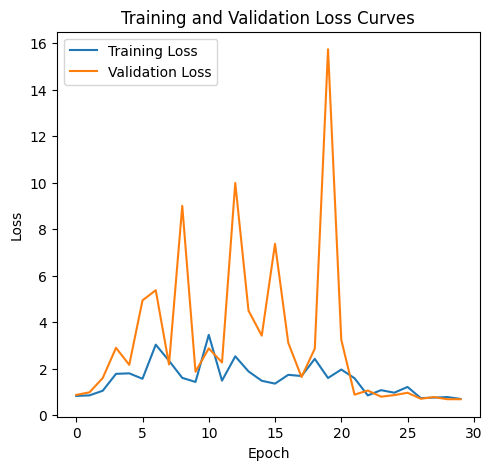

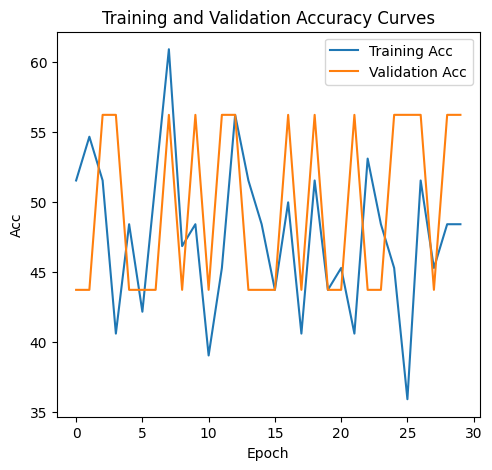

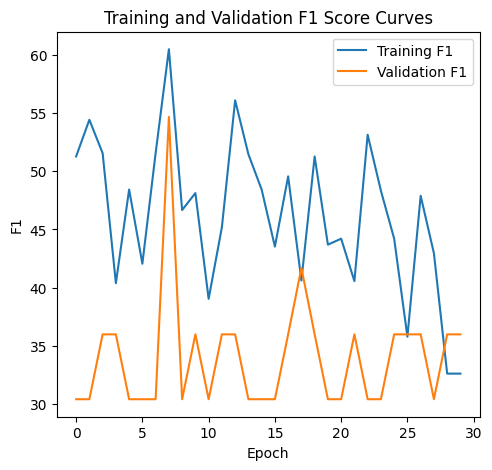

In [25]:
def main():

    seed_everything(config.seed)

    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    # DataLoader
    train_data = df.iloc[train_ids]
    valid_data = df.iloc[valid_ids]
    train_dataset = MRI3DDataset(train_data, mode = "train", transforms = build_transform(True))
    valid_dataset = MRI3DDataset(valid_data, mode = "valid", transforms = build_transform(False))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes', num_classes)
    model = Resnet3d(num_classes=num_classes, features_grad=False)
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad]
    
    # 選擇適當的 optimizer, scheduler
    optimizer = torch.optim.Adam(parameters, lr=config.lr, weight_decay=config.weight_decay)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=config.lr,
        steps_per_epoch=len(train_loader),
        epochs=config.epochs,
        anneal_strategy='cos'
    )

    # recordings
    best_val_loss = float("inf")
    early_stop_counter = 0
    early_stop_patience = 30
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_3D.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

        best_ckpt = torch.load("checkpoint_3D.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])

    valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_dataset
    del valid_dataset
    del train_loader
    del valid_loader
    gc.collect()
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["loss"])), history["train"]["loss"], label='Training Loss')
    plt.plot(range(len(history["valid"]["loss"])), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["acc"])), history["train"]["acc"], label='Training Acc')
    plt.plot(range(len(history["valid"]["acc"])), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["f1"])), history["train"]["f1"], label='Training F1')
    plt.plot(range(len(history["valid"]["f1"])), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()



In [26]:
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))
test_dataset = MRI3DDataset(test_df, mode = "test", transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

model = Resnet3d(num_classes = 2).to("cuda")

best_ckpt = torch.load("checkpoint_3D.pth", map_location=config.device)
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


loading pretrained model /kaggle/input/pretrain/resnet_50.pth


In [27]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("3D.csv", index=False)